# Notebook 1

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
import sys
import os
sys.path.append('../src/features')
from build_features import fill_nulls, filter_col_with_regex, get_dummies
sys.path.append('../src/models')
from predict_model import create_perf_metrics

In [3]:
# read in data 
df = pd.read_csv('../data/raw/20161201_voter_study_group.csv')
# fill null values 
df = fill_nulls(df)

In [4]:
# set regex pattern to find predictor column names
pattern = '(imiss_).{1}(_2016)'
# return list of predictor column names
col_list = filter_col_with_regex(df, pattern)
# save predictor subset of dataframe 
df_issue = df[col_list]
# one hot encoding categorical variables 
df_issue = get_dummies(df_issue)

# save target subset of dataframe
df_target = pd.DataFrame(df['presvote16post_2016'])

# predictors and target
df_target_issue = df_target.join(df_issue)
# correlation coefficients 
df_target_issue.corr()['presvote16post_2016'].abs().sort_values(ascending=False).head(10)

presvote16post_2016    1.000000
imiss_l_2016_1.0       0.271828
imiss_d_2016_1.0       0.260236
imiss_u_2016_1.0       0.242079
imiss_y_2016_1.0       0.237089
imiss_l_2016_4.0       0.212023
imiss_x_2016_1.0       0.211060
imiss_p_2016_1.0       0.208277
imiss_g_2016_1.0       0.200187
imiss_u_2016_3.0       0.177785
Name: presvote16post_2016, dtype: float64

In [11]:
df_3_cats = df_target['presvote16post_2016'].replace(
    to_replace=[0, 3, 4, 5, 6, 7],
    value=0,
    inplace=False
)              

In [12]:
# predictors 
X = df_issue
# target as array 
y = np.ravel(df_3_cats)

In [59]:
sys.path.append('../data/processed/')
with open('predictor.pickle', 'wb') as file:
    pickle.dump(X, file)
with open('target.pickle', 'wb') as file:
    pickle.dump(y, file)

In [13]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    stratify=y)

## Logistic regression

In [17]:
log_reg = LogisticRegression(C=2, penalty='l2', 
                        solver='lbfgs', 
                        multi_class='auto', 
                        max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_test = log_reg.predict(X_test)

In [18]:
# call performance metric function
log_reg_metrics = create_perf_metrics(y_test, y_pred_test)

                Pred Nonvoter/Other  Pred Clinton  Pred Trump
Nonvoter/Other                   14            92          89
Clinton                          16           630          63
Trump                            10            74         612 


 88.9 percent that were predicted Clinton were actually Clinton
 87.9 percent that were predicted Trump were actually Trump



In [19]:
# storing each group's coeficients as dicts
other_list = log_reg.coef_[0]
other_coef = dict(zip(X.columns, other_list))
clinton_list = log_reg.coef_[1]
clinton_coef = dict(zip(X.columns, clinton_list))
trump_list = log_reg.coef_[2]
trump_coef = dict(zip(X.columns, trump_list))

## Random forest

In [20]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)

In [21]:
rf_metrics = create_perf_metrics(y_test, y_pred_test)

                Pred Nonvoter/Other  Pred Clinton  Pred Trump
Nonvoter/Other                    9            93          93
Clinton                          10           626          73
Trump                             4            69         623 


 88.3 percent that were predicted Clinton were actually Clinton
 89.5 percent that were predicted Trump were actually Trump



## K Nearest Neighbors

In [22]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)

In [23]:
knn_metrics = create_perf_metrics(y_test, y_pred_test)

                Pred Nonvoter/Other  Pred Clinton  Pred Trump
Nonvoter/Other                   23            87          85
Clinton                          30           609          70
Trump                            28            81         587 


 85.9 percent that were predicted Clinton were actually Clinton
 84.3 percent that were predicted Trump were actually Trump



## Support vector machines

In [24]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_test = svm.predict(X_test)

In [27]:
# call performance metric function
svm_metrics = create_perf_metrics(y_test, y_pred_test)

                Pred Nonvoter/Other  Pred Clinton  Pred Trump
Nonvoter/Other                   17            93          85
Clinton                          16           628          65
Trump                            11            74         611 


 88.6 percent that were predicted Clinton were actually Clinton
 87.8 percent that were predicted Trump were actually Trump



## K-means clustering

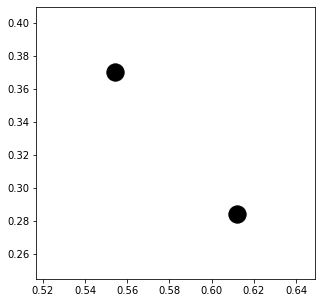

In [35]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

labels = kmeans.labels_
plt.figure(figsize=(5,5))
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=300)

y_pred = kmeans.predict(X)
metrics.silhouette_score(X, labels, metric='euclidean')
metrics.calinski_harabasz_score(X, labels)

y_pred_df = pd.DataFrame(y_pred, columns=['predicted'])
d = df_target.join(y_pred_df)
num_cluster_trump = d.loc[(d.presvote16post_2016 == 2) & (d.predicted == 0)].count()
num_cluster_clinton = d.loc[(d.presvote16post_2016 == 1)].count()